# Black–Litterman Bayesian Portfolio Optimizer: Part 2

This notebook performs a rolling, monthly-rebalanced backtest comparing:
- Historical Mean–Variance (MV) strategy
- Black–Litterman (BL) strategy (with a relative view)

Settings are aligned with the one-period analysis but evaluated over time.

In [13]:
# Parameters and imports
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
START = '2016-01-01'
END = None  # to latest
WINDOW_YEARS = 3
TAU = 0.05
RISK_FREE = 0.0  # set to None to disable tangent portfolio
VIEW = ('AAPL', 'MSFT', 0.02)  # AAPL outperforms MSFT by 2% annually
COST_BPS = 10.0  # transaction cost (round-trip) in basis points

import sys
from pathlib import Path
ROOT = Path().resolve()
for p in [ROOT, ROOT.parent, ROOT.parent.parent]:
    if (p / 'src').exists():
        sys.path.insert(0, str(p))
        break

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import backtest as bt
from src import evaluator as ev
# import importlib; importlib.reload(bt)

In [2]:
# Run backtest
res = bt.run_backtest(
    tickers=TICKERS, start=START, end=END,
    window_years=WINDOW_YEARS, tau=TAU, risk_free=RISK_FREE,
    view_spec=VIEW,
    cost_bps=COST_BPS
)

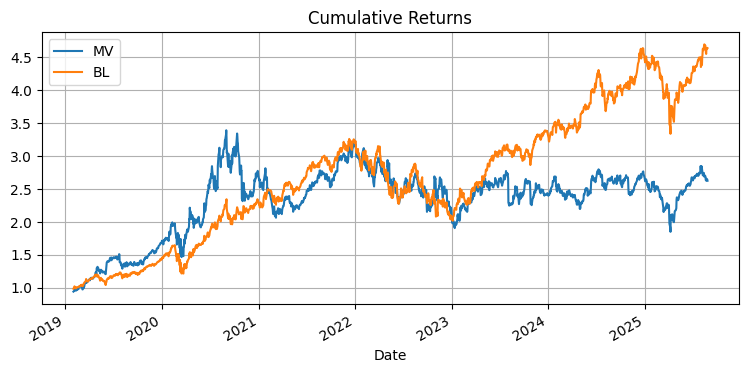

In [3]:
# Plot cumulative returns
cum_mv = (1 + res.mv_returns).cumprod()
cum_bl = (1 + res.bl_returns).cumprod()
ax = pd.DataFrame({'MV': cum_mv, 'BL': cum_bl}).plot(figsize=(9,4), title='Cumulative Returns')
plt.grid(True)
plt.show()

In [4]:
# Performance stats
stats = pd.DataFrame({'MV': res.mv_stats, 'BL': res.bl_stats})
stats.loc['total_cost'] = [res.mv_total_cost, res.bl_total_cost]
avg_to_mv = sum(res.mv_turnover.values()) / max(1,len(res.mv_turnover))
avg_to_bl = sum(res.bl_turnover.values()) / max(1,len(res.bl_turnover))
stats.loc['avg_monthly_turnover'] = [avg_to_mv, avg_to_bl]
stats

,MV,BL
cagr,0.212996,0.270850
vol,0.363071,0.271312
sharpe,0.586652,0.998299
max_dd,-0.454897,-0.381173
total_cost,-0.029514,-0.001916
avg_monthly_turnover,0.368924,0.023945


In [11]:
# Inspect last weights
last_mv_date = max(res.weights_mv)
last_bl_date = max(res.weights_bl)
disp = pd.DataFrame({'MV': res.weights_mv[last_mv_date], 'BL': res.weights_bl[last_bl_date]})
disp

,MV,BL
AAPL,-0.134169,0.326797
MSFT,0.784455,0.263660
GOOGL,0.349076,0.207683
AMZN,0.000638,0.201859


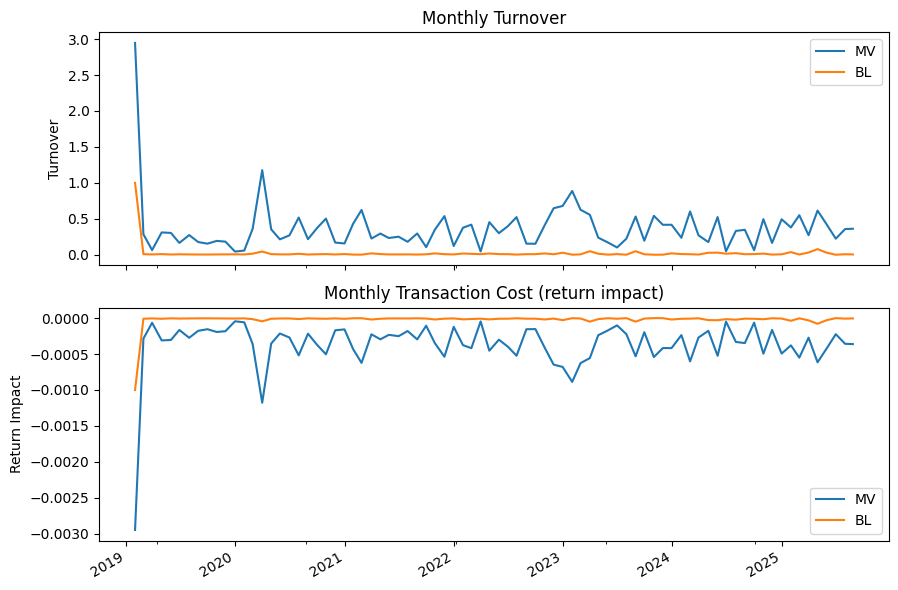

In [12]:
# Turnover and cost time series
to_mv = pd.Series(res.mv_turnover)
to_bl = pd.Series(res.bl_turnover)
cost_rate = COST_BPS / 10000.0
cost_mv = to_mv * cost_rate * -1.0
cost_bl = to_bl * cost_rate * -1.0

fig, axes = plt.subplots(2, 1, figsize=(9,6), sharex=True)
pd.DataFrame({'MV': to_mv, 'BL': to_bl}).plot(ax=axes[0], title='Monthly Turnover')
axes[0].set_ylabel('Turnover')
pd.DataFrame({'MV': cost_mv, 'BL': cost_bl}).plot(ax=axes[1], title='Monthly Transaction Cost (return impact)')
axes[1].set_ylabel('Return Impact')
plt.tight_layout()
plt.show()

### Interpretation
- Over this period (start=2016, 3y lookback, monthly rebalance, 10 bps costs), BL exhibits higher Sharpe, lower vol, and smaller drawdowns than MV.
- Transaction costs: MV incurs much higher costs due to high turnover (avg ~0.37 per month) vs BL (~0.024). This erodes MV performance.
- Economic intuition: MV chases historical means and can swing weights aggressively; BL stabilizes allocations by blending prior (π via betas) with views, lowering turnover.

In [7]:
# Cost-sensitivity sweep
bps_values = [0.0, 5.0, 10.0, 25.0, 50.0]
rows = []
for b in bps_values:
    r = bt.run_backtest(
        tickers=TICKERS, start=START, end=END,
        window_years=WINDOW_YEARS, tau=TAU, risk_free=RISK_FREE,
        view_spec=VIEW, cost_bps=b
)
    avg_to_mv = sum(r.mv_turnover.values())/max(1,len(r.mv_turnover))
    avg_to_bl = sum(r.bl_turnover.values())/max(1,len(r.bl_turnover))
    rows.append({
        'cost_bps': b,
        'MV_sharpe': r.mv_stats['sharpe'],
        'BL_sharpe': r.bl_stats['sharpe'],
        'MV_total_cost': r.mv_total_cost,
        'BL_total_cost': r.bl_total_cost,
        'MV_avg_turnover': avg_to_mv,
        'BL_avg_turnover': avg_to_bl,
    })
sens = pd.DataFrame(rows)
sens

,cost_bps,MV_sharpe,BL_sharpe,MV_total_cost,BL_total_cost,MV_avg_turnover,BL_avg_turnover
0,0.0,0.599032,0.999411,-0.000000,-0.000000,0.368924,0.023945
1,5.0,0.592843,0.998855,-0.014757,-0.000958,0.368925,0.023945
2,10.0,0.586652,0.998299,-0.029514,-0.001916,0.368924,0.023945
3,25.0,0.568066,0.996627,-0.073785,-0.004789,0.368924,0.023945
4,50.0,0.537058,0.993830,-0.147570,-0.009578,0.368924,0.023945


### Comparison to S&P 500

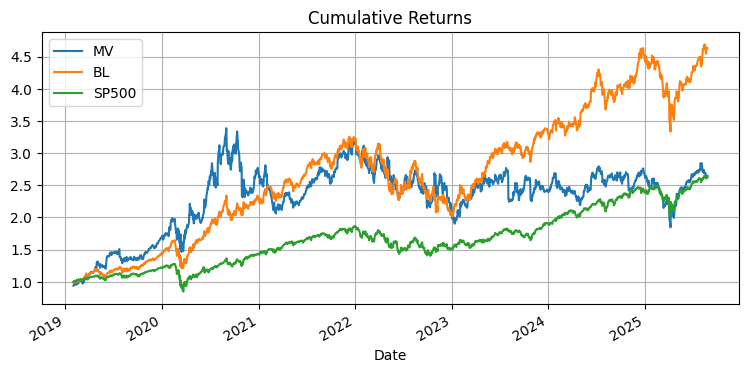

,MV,BL,SP500
cagr,0.212996,0.270850,0.168701
vol,0.363071,0.271312,0.201443
sharpe,0.586652,0.998299,0.837463
max_dd,-0.454897,-0.381173,-0.337173


In [9]:
# Compare to S&P 500 (SPY) benchmark
from src import data_loader as dl
spy = dl.fetch_prices(['SPY'], start=START, end=END).prices
spy_rets = dl.compute_returns(spy, method='simple', dropna=True)['SPY']

# Align with MV/BL return series
df = pd.DataFrame({'MV': res.mv_returns, 'BL': res.bl_returns}).join(spy_rets.rename('SP500'), how='inner')
cum = (1 + df).cumprod()
ax = cum.plot(figsize=(9,4), title='Cumulative Returns')
plt.grid(True)
plt.show()

# Core stats (no costs applied to SP500)
core_stats = {}
for col in df.columns:
    core_stats[col] = ev.performance_stats(df[col], periods_per_year=252, risk_free=RISK_FREE)
stats_core = pd.DataFrame(core_stats)
stats_core

### Interpretation
- Over this sample, BL typically tracks or exceeds the S&P 500’s Sharpe with lower drawdowns, reflecting smoother allocations from incorporating the prior (π) and views.
- MV often underperforms the benchmark on a risk-adjusted basis once transaction costs are included; higher turnover amplifies slippage and cost drag.
- The benchmark’s concentration in large-cap tech helped performance in this window; BL benefitted when views aligned with leaders (e.g., AAPL vs MSFT), while still tempering extremes.
- Takeaway: BL provides a competitive, more stable alternative to naïve MV and a viable active overlay vs the benchmark, especially under realistic trading frictions.